# Imports

In [1]:
import sys
import pathlib
import joblib
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

if pathlib.Path().parent.resolve().absolute().as_posix() not in sys.path:
    sys.path.append(pathlib.Path().parent.resolve().absolute().as_posix())

from pilot import Pilot, ensemble

%load_ext autoreload
%autoreload 2

# Load data

In [2]:
DATAPATH = pathlib.Path().absolute() / 'Data'
datasets = {
    'abalone': {'categorical': [0]}, # sex
    'airfoil': {'categorical': [-1]},
    'Bias_correction_ucl': {'categorical': [0]}, # station 
    'bodyfat_preprocessed': {'categorical': [-1]},
    'boston': {'categorical': [3]}, # Charles river dummy
    'communities': {'categorical': [-1]}, # 119 = LemasGangUnitDeploy
    'concrete': {'categorical': [-1]},
    'diabetes': {'categorical': [-1]},
    'electricity': {'categorical': [-1]},
    'energy': {'categorical': [5]}, # Orientation (X6)
    'ga_preprocessed': {'categorical': [6]}, # Research
    'housing': {'categorical': [-1]},
    'ozone_preprocessed': {'categorical': [10, 11]},
    'residential': {'categorical': [-1]},
    'ribo_preprocessed': {'categorical': [-1]},
    'SeoulBikeData': {'categorical': [-1]}, # 10 = seasons
    'skills': {'categorical': [-1]},
    'superconductor': {'categorical': [-1]},
    'Walmart_preprocessed': {'categorical': [0]},
    'wine': {'categorical': [-1]}
}

In [3]:
for d in datasets:
    df = pd.read_csv(DATAPATH / f'{d}.csv')
    X = df.drop(columns='target').values
    y = df['target'].values
    datasets[d]['data'] = X, y

# Fit baseline model

In [21]:
for d, data in datasets.items():
    model = Pilot.PILOT()
    tree = DecisionTreeRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=10)
    X, y = data['data']
    model.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    print(
        d, 
        round(r2_score(y, model.predict(X)), 2),
        round(r2_score(y, tree.predict(X)), 2)
    )
    

abalone 0.53 0.76
airfoil 0.87 0.91
Bias_correction_ucl 0.91 0.94
bodyfat_preprocessed 0.7 0.84
boston 0.88 0.94
communities 0.69 0.9
concrete 0.9 0.94
diabetes 0.48 0.77
electricity 0.88 0.93
energy 0.97 0.97
ga_preprocessed 0.81 0.89
housing 0.85 0.86
ozone_preprocessed 0.76 0.9
residential 0.99 0.98
SeoulBikeData 0.89 0.93
skills 0.6 0.83
superconductor 0.93 0.93
Walmart_preprocessed 0.95 0.97
wine 0.39 0.7


# Hyperparameter tuning : truncation factor

In [20]:
results = {}
for d, data in datasets.items():
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(estimator=Pilot.PILOT(), param_grid={'max_depth': [10], 'truncation_factor': [1, 1.5, 2, 2.5, 3]}, scoring='r2', cv=5)
    tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [10]}, scoring='r2', cv=5)
    lr = GridSearchCV(estimator=LinearRegression(), param_grid={}, scoring='r2', cv=5)
    X, y = data['data']
    pilot.fit(X, y, categorical=np.array(data['categorical']))
    tree.fit(X, y)
    lr.fit(X, y)
    print(
        d, 
        round(pilot.best_score_, 2),
        round(tree.best_score_, 2),
        round(lr.best_score_, 2)
    )
    results[d] = pilot.cv_results_

abalone 0.42 0.09 0.41
airfoil 0.54 0.57 0.41
Bias_correction_ucl 0.62 0.51 0.69
bodyfat_preprocessed 0.59 -0.01 0.58
boston 0.48 0.1 0.35
communities 0.62 0.3 -2.89
concrete 0.58 0.27 0.46
diabetes 0.46 -0.12 0.48
electricity 0.87 0.74 0.65
energy 0.94 0.94 0.87
ga_preprocessed 0.79 0.6 0.81
housing 0.48 -0.34 0.5
ozone_preprocessed 0.41 0.08 0.51
residential 0.95 0.87 0.92
ribo_preprocessed -0.46 -0.34 0.53
SeoulBikeData 0.32 0.48 -0.49
skills 0.57 0.31 0.56
Walmart_preprocessed -5.63 -1.02 -0.28
wine 0.29 -0.03 0.25


In [30]:
df = pd.concat([
    pd.DataFrame(results[d])[['param_truncation_factor', *[f'split{i}_test_score' for i in range(5)]]].melt(
        id_vars='param_truncation_factor'
    ).groupby('param_truncation_factor')['value'].mean().rename(d)
    for d in results
    ], axis=1).T

df

param_truncation_factor,1.0,1.5,2.0,2.5,3.0
abalone,0.422345,0.422345,0.422345,0.422345,0.422345
airfoil,0.541550,0.542491,0.542491,0.542491,0.539009
Bias_correction_ucl,0.619869,0.621468,0.621468,0.621468,0.621468
bodyfat_preprocessed,0.580666,0.586711,0.586711,0.586711,0.586711
boston,0.477665,0.472961,0.472961,0.472961,0.472961
communities,0.619019,0.617436,0.617211,0.617211,0.617211
concrete,0.581790,0.579031,0.576597,0.579031,0.579031
diabetes,0.458325,0.458325,0.458325,0.458325,0.458325
electricity,0.873663,0.872209,0.872209,0.872209,0.872209
energy,0.936738,0.936738,0.936738,0.936738,0.936738


In [16]:
def highlight(data, kind='max', color='black', background_color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'color: {}; background-color: {}'.format(color, background_color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        if kind == 'max':
            highlight = data == data.max()
        elif kind == 'min':
            highlight = data == data.min()
        return [attr if v else '' for v in highlight]
    else:  # from .apply(axis=None)
        if kind == 'max':
            highlight = data == data.max().max()
        elif kind == 'min':
            highlight = data == data.min().min()
        return pd.DataFrame(np.where(highlight, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
df.style.apply(partial(highlight, kind='max'), axis=1).format('{:.3f}')



# Hyperparameter tuning: Random Forest

## Run grid

In [10]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

In [ ]:
results = {}
for i, (d, data) in enumerate(datasets.items()):
    print(i)
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2, 10],
            'min_sample_leaf':  [1],
            'n_features': [1.0]
        }, 
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf':  [1],
            'max_features': [1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=5,
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, OUTPUTPATH / 'rf_gridsearch_v2.pkl')

## Rerun on Electricity,  Walmart, Boston, Abalone, Communities, Housing, Ribo

After adding rel_tolerance parameter to avoid recursion errors

In [5]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'

In [11]:
results =  joblib.load(OUTPUTPATH / 'rf_gridsearch_v3.pkl')
results.keys()

dict_keys(['electricity', 'Walmart_preprocessed', 'boston', 'abalone', 'communities', 'housing', 'ribo_preprocessed'])

In [ ]:
# datasets_selected = ['electricity', 'Walmart_preprocessed', 'boston', 'abalone', 'communities', 'housing', 'ribo_preprocessed']
datasets_selected = ['ribo_preprocessed']
# results = {}
for i, d in enumerate(datasets_selected):
    print(i)
    data = datasets[d]
    if d == 'superconductor':
        continue
    pilot = GridSearchCV(
        estimator=ensemble.RandomForestPilot(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'truncation_factor': [1.5],
            'min_sample_split': [2, 10],
            'min_sample_leaf':  [1],
            'n_features': [1.0],
            'rel_tolerance': [0.01],
        }, 
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    tree = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': [50],
            'max_depth': [2, 10],
            'min_samples_split': [2, 10],
            'min_samples_leaf':  [1],
            'max_features': [1.0]
        },
        scoring='neg_mean_squared_error', 
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

    X, y = data['data']
    
    pilot.fit(X, y, categorical_idx=np.array(data['categorical']))
    tree.fit(X, y)

    
    print(d, round(pilot.best_score_, 2), round(tree.best_score_, 2))
    
    results[d] = {'pilot': pilot.cv_results_, 'rf': tree.cv_results_}
    joblib.dump(results, OUTPUTPATH / 'rf_gridsearch_v3.pkl')

In [12]:
previous_results = joblib.load( OUTPUTPATH / 'rf_gridsearch_v2.pkl')
previous_results.update(results)

joblib.dump(previous_results, OUTPUTPATH / 'rf_gridsearch_v4.pkl')

['/home/servot82/PILOT/Output/rf_gridsearch_v4.pkl']

## Inspect results

In [13]:
OUTPUTPATH = pathlib.Path().absolute() / 'Output'
results = joblib.load( OUTPUTPATH / 'rf_gridsearch_v4.pkl')

<AxesSubplot: ylabel='dataset'>

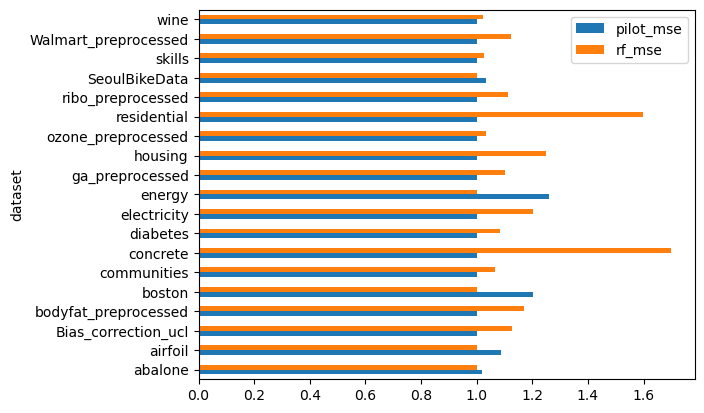

In [14]:
normalized_results = pd.DataFrame([{
    'dataset': d, 
    'pilot_mse': -np.nanmax(r['pilot']['mean_test_score']), 
    'rf_mse': -np.nanmax(r['rf']['mean_test_score'])
    } for d, r in results.items()]).set_index('dataset').apply(lambda row: row / row.min(), axis=1)

normalized_results.plot.barh()

In [18]:
normalized_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')


,pilot_mse,rf_mse
dataset,,
abalone,1.021,1.000
airfoil,1.088,1.000
Bias_correction_ucl,1.000,1.128
bodyfat_preprocessed,1.000,1.170
boston,1.203,1.000
communities,1.000,1.067
concrete,1.000,1.698
diabetes,1.000,1.082
electricity,1.000,1.202


### Deep dive max depth

In [19]:
max_depth_results = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_max_depth'])['mean_test_score'].mean().unstack()
max_depth_results *= -1
max_depth_results = max_depth_results.apply(lambda row: row / row.min(), axis=1)
max_depth_results.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_max_depth,2,10
dataset,,
Bias_correction_ucl,1.013,1.000
SeoulBikeData,2.423,1.000
Walmart_preprocessed,2.341,1.000
abalone,1.055,1.000
airfoil,1.642,1.000
bodyfat_preprocessed,1.022,1.000
boston,1.489,1.000
communities,1.064,1.000
concrete,1.374,1.000


### Deep dive min samples split

In [20]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split'])['mean_test_score'].mean().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

param_min_sample_split,2,10
dataset,,
Bias_correction_ucl,1.012,1.000
SeoulBikeData,1.000,1.024
Walmart_preprocessed,1.005,1.000
abalone,1.000,1.001
airfoil,1.000,1.003
bodyfat_preprocessed,1.008,1.000
boston,1.000,1.003
communities,1.000,1.001
concrete,1.000,1.001


### Deep dive max depth &  min samples split

In [17]:
df = pd.concat([pd.DataFrame(results[d]['pilot']).assign(dataset=d) for d in results]).groupby(['dataset', 'param_min_sample_split', 'param_max_depth'])['mean_test_score'].mean().unstack().unstack()
df *= -1
df = df.apply(lambda row: row / row.min(), axis=1)
df.style.apply(partial(highlight, kind='min'), axis=1).format('{:.3f}')

In [43]:
pd.DataFrame(results['abalone']['pilot'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_sample_leaf,param_min_sample_split,param_n_estimators,param_n_features,param_truncation_factor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.796281,2.020451,3.349500,0.400117,2,1,2,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-10.939442,-2.952053,-5.577138,-3.632847,-3.987102,-5.417716,2.892293,3
1,23.323216,1.119977,3.201397,0.449936,2,1,10,50,1.0,1.5,"{'max_depth': 2, 'min_sample_leaf': 1, 'min_sa...",-10.883988,-2.978976,-5.577490,-3.598518,-4.017543,-5.411303,2.867852,2
2,30.396328,3.130993,3.313691,1.698185,10,1,2,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",-10.188859,-2.682452,NaN,-3.416042,-3.750725,NaN,NaN,4
3,30.004525,1.881924,3.321904,0.246008,10,1,10,50,1.0,1.5,"{'max_depth': 10, 'min_sample_leaf': 1, 'min_s...",-10.105636,-2.691930,-5.310696,-3.411045,-3.682005,-5.040262,2.673762,1


# Investigate bad performance

## Walmart

In [137]:
pd.read_csv(DATAPATH / 'Walmart_preprocessed.csv')

,Store,target,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,1
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,4,9,3
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,4,10,3
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,4,10,3
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,4,10,3


In [138]:
X[:5]

array([[  1.       ,   0.       ,  42.31     ,   2.572    , 211.0963582,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   1.       ,  38.51     ,   2.548    , 211.2421698,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  39.93     ,   2.514    , 211.2891429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.63     ,   2.561    , 211.3196429,
          8.106    ,   4.       ,   2.       ,   1.       ],
       [  1.       ,   0.       ,  46.5      ,   2.625    , 211.3501429,
          8.106    ,   4.       ,   3.       ,   1.       ]])

In [139]:
X, y = datasets['Walmart_preprocessed']['data']
categorical = datasets['Walmart_preprocessed']['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

np.random.seed(101)
scores = cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error')
p_mse = -np.mean(scores)
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

2.7791366601220706 1.0


In [144]:
cv = KFold(5, shuffle=True)
scores = []
for train_idx, test_idx in cv.split(X):
    p = Pilot.PILOT()
    p.fit(X[train_idx, :], y[train_idx], categorical=np.array(categorical))
    scores.append(mean_squared_error(y[test_idx], p.predict(X[test_idx])))

[f'{m:.2e}' for m in scores]
    

['1.64e+10', '1.58e+10', '1.76e+10', '1.99e+10', '1.93e+10']

In [9]:
X_enc = OneHotEncoder().fit_transform(X[:, [0]]).toarray()
X_enc = np.hstack([X_enc, X[:, 1:]])
print(X.shape, X_enc.shape)

p2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
d2_mse = -np.mean(cross_val_score(d, X_enc, y, scoring='neg_mean_squared_error'))
print(p_mse / min(p_mse, d_mse, d2_mse, p2_mse), p2_mse / min(p_mse, d_mse, d2_mse, p2_mse), d_mse / min(p_mse, d_mse, d2_mse, p2_mse), d2_mse / (min(p_mse, d_mse, d2_mse, p2_mse)))

(6435, 9) (6435, 53)
2.788660598687874 1.013677496545187 1.0 1.0136774965451865


In [10]:
f'{p_mse:.2e}, {p2_mse:.2e}, {d2_mse:.2e}'

'1.42e+12, 5.15e+11, 5.15e+11'

## Electricity

In [4]:
dname = 'electricity'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.8729348495313307


In [17]:
results['electricity']['pilot']['mean_test_score'], results['electricity']['rf']['mean_test_score']

(array([-0.00049177, -0.00048808,         nan,         nan]),
 array([-0.0009364 , -0.00092756, -0.00016658, -0.00016975]))

In [ ]:
prf = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5)
results = cross_validate(prf, X, y, scoring='neg_mean_squared_error', n_jobs=-1, fit_params={'categorical_idx': np.array(categorical)}, return_estimator=True)


In [9]:
p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.01)
bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

p.model_tree.nodes_selected()

{'con': 2, 'lin': 4, 'blin': 5, 'pcon': 1, 'plin': 0}

## Boston

In [14]:
dname = 'boston'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.1748315721418028


In [37]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

7 blin {'con': 0, 'lin': 0, 'blin': 1, 'pcon': 0, 'plin': 0} {'lin': 2963, 'blin': 10, 'pcon': 1, 'plin': 3, 'pconc': 1}


Exception: 

## Skills

In [35]:
dname = 'skills'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.4863177817216304


## Wine

In [36]:
dname = 'wine'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.3978899488124397


## Abalone

In [38]:
dname = 'abalone'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.2649648675728686


In [39]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

In [40]:
rfp = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0)
for train_idx, test_idx in KFold().split(X, y):
    rfp.fit(X[train_idx, :], y[train_idx])
    print(r2_score(y[test_idx], rfp.predict(X[test_idx, :])))

0.4098002559030295
0.2847848498919635
0.5401221094057291
0.5656876172648391
0.48212196709914723


## Bike

In [41]:
dname = 'SeoulBikeData'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0587370965296532 1.0


In [42]:
datasets[dname]['categorical']

[-1]

## California

In [43]:
dname = 'housing'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.252993057125518


## Communities

In [44]:
dname = 'communities'
X, y = datasets[dname]['data']
categorical = datasets[dname]['categorical']
p = Pilot.PILOT()
d = DecisionTreeRegressor(max_depth=12, min_samples_split=10, min_samples_leaf=5)

p_mse = -np.mean(cross_val_score(p, X, y, fit_params={'categorical': np.array(categorical)}, scoring='neg_mean_squared_error'))
d_mse = -np.mean(cross_val_score(d, X, y, scoring='neg_mean_squared_error'))

print(p_mse / min(p_mse, d_mse), d_mse / (min(p_mse, d_mse)))

1.0 1.4973791251675714


In [45]:
for i in range(100):
    p = Pilot.PILOT(max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0.00)
    bootstrap_idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    p.fit(X[bootstrap_idx, :], y[bootstrap_idx], categorical=np.array(categorical))

6 plin {'con': 1, 'lin': 29, 'blin': 1, 'pcon': 0, 'plin': 1} {'lin': 3341, 'blin': 21, 'pcon': 5, 'plin': 10, 'pconc': 0}


Exception: 

In [ ]:
rfp = ensemble.RandomForestPilot(n_estimators=50, max_depth=10, min_sample_split=2, truncation_factor=1.5, rel_tolerance=0)
for train_idx, test_idx in KFold().split(X, y):
    rfp.fit(X[train_idx, :], y[train_idx])
    print(r2_score(y[test_idx], rfp.predict(X[test_idx, :])))

0.4098002559030295
0.2847848498919635
0.5401221094057291
0.5656876172648391
0.48212196709914723
